In [133]:
# Paquetes y comandos de interés a importar:

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from math import pi
from scipy.optimize import curve_fit
plt.rcParams['figure.dpi']= 90
from PIL import Image
from scipy.fft import fft
import scipy.signal as signal

In [134]:
# Abrimos la ROI del borde seleccionado

I=Image.open("6cm_run4_cropV.tif")
print(I.format, I.size, I.mode)
#I.show()

I_arr=np.asarray(I) # conversión de imagen .tif a array de 300 filas por 300 columnas.

print('valor mínimo:',np.min(I_arr)); print('valor máximo:',np.max(I_arr)) 

TIFF (300, 300) L
valor mínimo: 0
valor máximo: 187


In [135]:
# Normalizamos los valores del array I en un intervalo de niveles de gris [0,GL_max]

def norm(image,GL_max):
    GL=np.zeros((len(image),len(image)))
    GL = GL_max*((image-np.min(image))/(np.max(image)-np.min(image)))
    return GL.astype(int)

I_norm=norm(I_arr,255) #normalizamos a 255 niveles de gris

print('valor mínimo:',np.min(I_norm)); print('valor máximo:',np.max(I_norm))

I_norm_im=Image.fromarray(np.uint8(I_norm)) #lo convierto a imagen

I_norm_im.show()

# Continuaremos trabajando con I_norm, que es, como explicamos antes, la matriz de niveles de gris.

valor mínimo: 0
valor máximo: 255


Text(0, 0.5, 'I (a.u.)')

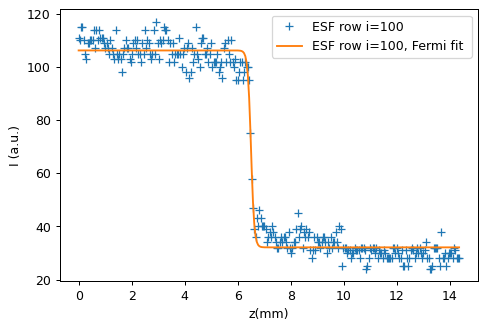

In [139]:
# Vamos a aplicar fermi por filas. El parámetro e es la posición en mm del borde (transición de blanco a negro) 
# en cada fila

def fermi(x,d,b,s,e):
    f = d + (b-d)/(1+np.exp(-s*(x-e))) 
    return f

# Para representar la ESF en función de la posición y no del pixel, necesitamos el tamaño de pixel (48 micras):

pixel_size=0.048 # en mm
image_len=np.sqrt(np.size(I_norm))

# Array que representa el ancho físico de cada fila:

width=np.arange(0,image_len*pixel_size,pixel_size) #de 0 hasta 14.4 (=300 píxeles * 0.048 mm) en pasos de 0.048

index=100 # escogemos la fila número 100 de la imagen, por ejemplo

plt.plot(width,I_norm[index,:],'+',label='ESF row i=100') # representamos

# Lo que viene a continuación es un ajuste por mínimos cuadrados (curve_fit). Ajustamos I_norm[100,:] versus width

pe,cove=curve_fit(fermi,width,I_norm[index,:]) 

I_fermi_100=fermi(width,*pe) # construimos una nueva fila 100, aplicando los parámetros de ajuste a width

plt.plot(width,I_fermi_100,label='ESF row i=100, Fermi fit ')

plt.legend()

plt.xlabel('z(mm)')
plt.ylabel('I (a.u.)')




Text(0.5, 0, 'z (mm)')

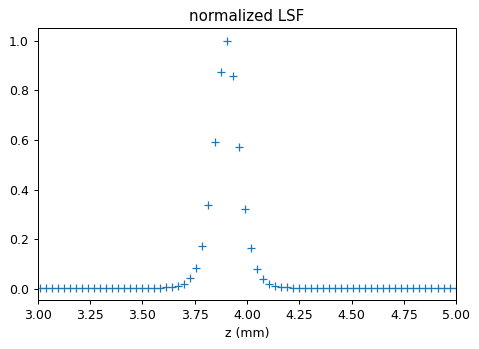

In [137]:
# Construimos la LSF como la derivada simple de la ESF.

LSF=1-np.diff(I_fermi_100)/np.diff(width) # Hago 1-derivada para que sea una función positiva.
LSF_norm=LSF/np.max(LSF) # normalizamos

# construimos un nuevo z que represente el centro de cada pixel, teniendo en cuenta la magnificación: 
width_diff=np.zeros(len(width)-1) 

m=15/9 # magnificación m=(9+6)/9, donde distancia fuente-borde = 9 cm y distancia borde-sensor = 6 cm.

for i in range(len(width)-1):
    width_diff[i] = ((width[i+1]+width[i])/2)/m 

plt.plot(width_diff,LSF_norm,'+')
plt.xlim([3,5])

plt.title('normalized LSF')

plt.xlabel('z (mm)')



[ 9.59487198e-01  3.90137517e+00  5.79088348e-02 -5.17804047e-04
  2.06198161e-02]
[0.01059268 0.00072676 0.00081092 0.02011421 0.07866262]
Sigma (mm) 0.05790883477930165
FWHM (mm)  0.13637530590525537
------Tamaño de foco en la dirección vertical-----------
136.37530590525537 micras


(3.0, 5.0)

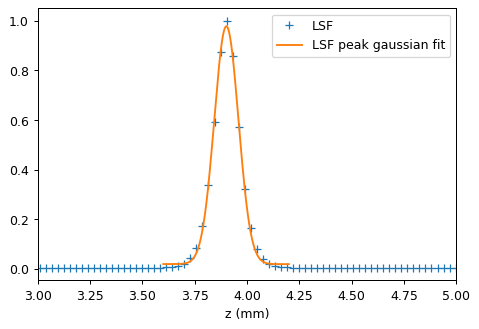

In [138]:
# Esto que viene a continuación es un ajuste gaussiano al pico de la LSF.

def gauss(x,a,b,c,d,f):
    gauss=a*np.exp((-(x-b)**2)/(2*c**2))+d*x+f
    return gauss

## Para aislar el pico, necesitamos estas dos funciones:

# Definimos selector de canales de posición:

def can(canal,counts,inf,sup):
    canal_lst=[] #definimos una lista vacía
    for i in range(len(canal)): #recorremos el array de canales
        if canal[i]>=inf and canal[i]<=sup: #[inf,sup] es el intervalo de canales a seleccionar
            canal_lst.append(canal[i]) 
    canal_arr=np.array(canal_lst) #convertimos la lista a array
    return canal_arr

# Definimos selector de amplitudes (intensidades):

def amp(canal,counts,inf,sup): #lo mismo que can() pero para obtener el array de amplitudes parejo al de canales
    ampl_lst=[]
    for i in range(len(canal)):
        if canal[i]>=inf and canal[i]<=sup:
            ampl_lst.append(counts[i])
    ampl_arr=np.array(ampl_lst)
    return ampl_arr


a=3.6
b=4.2

z_p=can(width_diff,LSF_norm,a,b) # selección del pico en términos de posición
LSF_p=amp(width_diff,LSF_norm,a,b) # selección del pico en términos de amplitud

p_g,cov_g=curve_fit(gauss,z_p,LSF_p,p0=[0.9,3.8,1E-1,0.1,0]) #p0 son parámetros iniciales, para que curve_fit converja
print(p_g)
print(np.sqrt(np.diag(cov_g)))


z_lin=np.linspace(a,b,1000)
LSF_lin=gauss(z_lin,*p_g)

plt.plot(width_diff,LSF_norm,'+', label='LSF')
plt.plot(z_lin,LSF_lin, label='LSF peak gaussian fit')
plt.xlabel('z (mm)')
plt.legend()

print('Sigma (mm)', p_g[2])
print('FWHM (mm) ', 2.355*p_g[2]) 

print('------Tamaño de foco en la dirección vertical-----------')
print(2.355*p_g[2]*1000,'micras')

plt.xlim([3,5])

